# Assignment 2

This assignment is about training and evaluating a POS tagger with some real data. The dataset is available through the Universal Dependencies (https://universaldependencies.org/) (UD) project. To get to know the project, please visit https://universaldependencies.org/introduction.html)

Do make sure all results are uploaded to CSVs (as well as printed to console) for your assignment to be fully graded.

In [66]:
#!pip install --q conllutils

In [67]:
import os
import random
from typing import List

import nltk
from nltk.tag import tnt 

import operator

import numpy as np
import pandas as pd
from tabulate import tabulate

import conllutils

## Part 1 - Dataset





For each package you use, set the random seed to 42.

In [68]:
# Set the random seed for Python
random.seed(42)

# Set the random seed for numpy
np.random.seed(42)

# Set the random seed for pandas
# To Do

# Set the random seed for NLTK
# To Do

You can download the dataset files directly from the UD website, but it will let you only download all the languages in one compressed file. In this assignment you will be working with th GUM dataset, which you can download directly from:
https://github.com/UniversalDependencies/UD_English-GUM.
Please download it to your colab machine.

In [69]:
!git clone https://github.com/UniversalDependencies/UD_English-GUM

fatal: destination path 'UD_English-GUM' already exists and is not an empty directory.


We will use the (train/dev/test) files:


```
UD_English-GUM/en_gum-ud-train.conllu
UD_English-GUM/en_gum-ud-dev.conllu
UD_English-GUM/en_gum-ud-test.conllu
```


They are all formatted in the conllu format. You may read about it [here](https://universaldependencies.org/format.html). There is a utility library **conllutils**, which can help you read the data into the memory. It has already been installed and imported above.

You should write a code that reads the three datasets into memory. You may choose the data structure by yourself. As you can see, every word is represented by a line, with columns representing specific features.   
We are only interested in the first and fourth columns, corresponding to the word and its POS tag:
- `ID: Word index`
- `UPOS: Universal part-of-speech tag` 

In [70]:
# TODO:
# set the file paths for the train, dev, and test datasets
train_path = 'UD_English-GUM/en_gum-ud-train.conllu'
dev_path = 'UD_English-GUM/en_gum-ud-dev.conllu'
test_path = 'UD_English-GUM/en_gum-ud-test.conllu'


In [71]:
# create a pipeline for processing of the sentences, which will:

# 1.Filter only syntactic words (i.e. skip the empty and multiword tokens).
# 2.Extract only Universal dependency relations without the language-specific extensions.
# 3.Generate a concatenated UPOS & FEATS field.
# 4.Transform FORM values to lowercase.
# 5.Replace numbers expressions in FORM field with the constant value.
from conllutils import pipe

NUM_REGEX = r'[0-9]+|[0-9]+\.[0-9]+|[0-9]+[0-9,]+'
NUM_FORM = '__number__'

p = pipe()
p.only_words()
p.only_universal_deprel()
p.upos_feats()
p.lowercase('form')
p.replace('form', NUM_REGEX, NUM_FORM)

In [72]:
from conllutils import create_inverse_index

# indexing sentences for machine learning
indexed_fields = {'form', 'upos'} # form is the word, upos is the tag

# train
train_index = pipe().read_conllu(train_path).pipe(p).create_index(fields=indexed_fields) # create index, which maps words to integers
train_inverse_index = create_inverse_index(train_index) # create inverse index, which maps integers to words
train_data = pipe().read_conllu(train_path).pipe(p).to_instance(train_index).collect() # create instances, which are lists of integers representing words

# dev
dev_index = pipe().read_conllu(dev_path).pipe(p).create_index(fields=indexed_fields)
dev_inverse_index = create_inverse_index(dev_index)
dev_data = pipe().read_conllu(dev_path).pipe(p).to_instance(dev_index).collect()

# test
test_index = pipe().read_conllu(test_path).pipe(p).create_index(fields=indexed_fields)
test_inverse_index = create_inverse_index(test_index)
test_data = pipe().read_conllu(test_path).pipe(p).to_instance(test_index).collect()

In [77]:
# explore the indexed data
print(f'train index type: {type(train_index)}')
print(f'train index size: {len(train_index)}')
print(f'train index keys: {train_index.keys()}')
print(f'train index example keys,values: {train_index["form"].items()}')

# explore the inverse index
print(f'train inverse index type: {type(train_inverse_index)}')
print(f'train inverse index size: {len(train_inverse_index)}')
print(f'train inverse index keys: {train_inverse_index.keys()}')

# print some data exploration, s.t data type, size, and some examples
print(f'train data type: {type(train_data)}')
print(f'train data size: {len(train_data)}')
print(f'train data example: {train_data[0]}')
print(f'train data example keys: {train_data[0].keys()}')

train index type: <class 'dict'>
train index size: 2
train index keys: dict_keys(['form', 'upos'])
train index example keys,values: dict_items([(',', 1), ('the', 2), ('.', 3), ('and', 4), ('of', 5), ('to', 6), ('a', 7), ('in', 8), ('__number__', 9), ('that', 10), ('i', 11), ('is', 12), ('it', 13), ('you', 14), ('for', 15), ('"', 16), ('was', 17), ('on', 18), ('-', 19), ('as', 20), ('this', 21), ('with', 22), ("'s", 23), ('we', 24), ('are', 25), ('at', 26), ('(', 27), (')', 28), ('have', 29), ('from', 30), ('by', 31), ('be', 32), ('or', 33), ('he', 34), ('not', 35), ('they', 36), ('do', 37), ('?', 38), ('but', 39), ('his', 40), ('so', 41), ('can', 42), ('like', 43), ('an', 44), ("n't", 45), ('your', 46), ('[', 47), (']', 48), ('if', 49), ('there', 50), ('one', 51), ('all', 52), ('she', 53), (':', 54), ('my', 55), ('which', 56), ('will', 57), ('what', 58), ('had', 59), ('her', 60), ('has', 61), ('when', 62), ('their', 63), ('more', 64), ('were', 65), ('’s', 66), ('“', 67), ('about', 68),

## Part 2 - Simpler Tagger

Write a class **simple_tagger**, with methods `train` and `evaluate`. 

The method `train` receives the data, and use it for training the tagger.   
In this case, it should learn a simple dictionary that **maps words to tags**, defined as the most frequent tag for every word (in case there is more than one most frequent tag, you may select one of them randomly). The dictionary should be stored as a class member for evaluation.

The method `evaluate` receives the data, and use it to evaluate the tagger performance. Specifically, you should calculate the word and sentence level accuracy.
The evaluation process is simply going word by word, querying the dictionary (created by the train method) for each word’s tag and compare it to the true tag of that word. 
 - The word-level accuracy is the number of successes divided by the number of words. For OOV (out of vocabulary, or unknown) words, the tagger should assign the most frequent tag in the entire training set (i.e., the mode). 
 - Calculate the sentence-level accuracy by dividing the number of correctly predicted sentences by the total number of sentences in the dataset.

The function should return the two numbers: word level accuracy and sentence level accuracy.

<br>

Notes:  
 - You may add functions to `simple_tagger`. 
 - Avoid using loops except when absolutely necessary!
 - Use numpy & pandas operations and function. For example, `apply`, `map`, `sum`, `unique`, etc.


In [130]:
class simple_tagger:
  """ A simple tagger class, which learns a dictionary mapping words to tags, and uses it for tagging new sentences.

    Attributes:
        _seperator: A string seperator for the word and tag in the dictionary.
        _word2tag: A dictionary mapping words to tags.
        _OOV: The most frequent tag in the training set, for out of vocabulary words.
    """
  def __init__(self) -> None:
    self._seperator = '\w'
    self._word2tag = {}
    self._OOV = None

  def _get_all_tags(self) -> List[str]:
    return list(self._word2tag.values())

  def train(self, data) -> None:
    """ Trains the tagger on the given data. i.e. learns a dictionary mapping words to tags.

    Args:
        data: A list of dictionaries, where each dictionary represents a sentence, and has the following keys:
            form: The Sentence, i.e. ndarray of words.
            upos: The tags, i.e. ndarray of tags corresponding to the words.

    Returns:
        None
    """
    # create a dataframe from the data
    data_df = pd.DataFrame(data)
    # create a dataframe with the sentences and tags
    sentences_df = data_df[['form', 'upos']]
    # create a dataframe with the words and tags (i.e. explode the sentences dataframe)
    words_df = sentences_df.explode('form').explode('upos')
    # create a dataframe with the words and their tags and their count
    words_count_df = words_df.groupby(['form', 'upos']).size().reset_index(name='count')
    # create a dataframe with the words and their most frequent tag
    words_most_frequent_tag_df = words_count_df.loc[words_count_df.groupby('form')['count'].idxmax()]
    # create a dictionary with the words and their most frequent tag
    self._word2tag = dict(zip(words_most_frequent_tag_df['form'], words_most_frequent_tag_df['upos']))
    # create a dictionary with the most frequent tag in the training set, for out of vocabulary words
    self._OOV = words_count_df.groupby('upos')['count'].sum().idxmax()

    pass

  def sentence_to_tags(self, sentence):
    """ Tags a sentence using the dictionary learned by the train method.

    Args:
        sentence: A ndarray of words.

    Returns:
        A ndarray of tags, corresponding to the words in the sentence.
    """
    word_to_tag = self._word2tag
    OOV = self._OOV

    # predict the tags for the words in the sentence
    tags = np.array([word_to_tag.get(word, OOV) for word in sentence])
    return tags

  def evaluate(self, data) -> tuple[float,float]:
      """ Evaluates the tagger on the given data. i.e. calculates the word and sentence level accuracy.

      Args:
          data: A list of dictionaries, where each dictionary represents a sentence, and has the following keys:
              form: The Sentence, i.e. ndarray of words.
              upos: The tags, i.e. ndarray of tags corresponding to the words.

      Returns:
          A tuple of floats, the word level accuracy and the sentence level accuracy.
      """
      word_to_tag = self._word2tag
      OOV = self._OOV
      # create a dataframe from the data
      data_df = pd.DataFrame(data)
      # create a dataframe with the sentences and tags
      sentences_df = data_df[['form', 'upos']]
      # create a dataframe with the words and tags (i.e. explode the sentences dataframe)
      words_df = sentences_df.explode('form').explode('upos')

      # predict the tags for the words in the sentences
      words = words_df['form'].to_numpy()
      tags = words_df['upos'].to_numpy()
      predicted_tags = words_df['form'].map(lambda word: word_to_tag.get(word, OOV)).to_numpy()
      # calculate the word level accuracy
      word_level_accuracy = np.sum(tags == predicted_tags) / len(tags)

      # predict the tags for the sentences
      sentences = sentences_df['form'].to_numpy()
      sentences_tags = sentences_df['upos'].to_numpy()
      predicted_sentences_tags = sentences_df['form'].map(lambda sentence: self.sentence_to_tags(sentence)).to_numpy()
      # calculate the sentence level accuracy
      sentence_level_accuracy = np.sum(sentences_tags == predicted_sentences_tags) / len(sentences_tags)
      print("first sentence:")
      print(f'sentence: {sentences[0]}')
      print(f'tags: {sentences_tags[0]}')
      print(f'predicted tags: {predicted_sentences_tags[0]}')
      print("last sentence:")
      print(f'sentence: {sentences[-1]}')
      print(f'tags: {sentences_tags[-1]}')
      print(f'predicted tags: {predicted_sentences_tags[-1]}')

      return word_level_accuracy, sentence_level_accuracy


In [131]:
train_data_df = pd.DataFrame(train_data)
train_data_df.head()

,form,head,upos
0,"[2424, 2852, 4, 521, 306, 54]","[2, 0, 5, 5, 2, 2]","[7, 1, 11, 7, 1, 2]"
1,"[2666, 30, 1227, 19, 1272]","[0, 5, 5, 3, 1]","[1, 4, 1, 2, 1]"
2,"[6288, 6441, 19, 2998, 11836, 180, 5, 8568, 1,...","[0, 1, 4, 2, 1, 1, 8, 6, 11, 11, 1]","[8, 8, 2, 8, 8, 8, 4, 8, 2, 3, 8]"
3,"[2861, 6402, 12815, 2744, 180, 1, 164, 1956]","[0, 1, 1, 5, 1, 8, 8, 1]","[8, 8, 8, 8, 8, 2, 3, 8]"
4,"[508, 3699, 11428, 2744, 180, 1, 164, 1956]","[0, 1, 1, 5, 1, 8, 8, 1]","[8, 8, 8, 8, 8, 2, 3, 8]"


**Train & Evaluate**  
Use the class you created to train and evaluate your model.
Save & Print the eveluation scores.

In [132]:
# create a simple tagger instance
simple_tagger_instance = simple_tagger()
# train the tagger
simple_tagger_instance.train(train_data)
# evaluate the tagger
word_level_accuracy, sentence_level_accuracy = simple_tagger_instance.evaluate(test_data)
# print the evaluation scores
print(f'word level accuracy: {word_level_accuracy}')
print(f'sentence level accuracy: {sentence_level_accuracy}')


first sentence:
sentence: [   1  829    4  130  287  339 3095    7 3546  285   47]
tags: [5 1 4 1 4 8 1 4 8 7 2]
predicted tags: [1 1 1 3 2 1 1 1 3 1 2]
last sentence:
sentence: [ 238    2   12  272 1016   81  453    4 1293   37  686    4 1257   21
   52 1319 1000    3]
tags: [10  2  6  9  3  8  1  4  1 11  1  4  1  4  6  1  1  2]
predicted tags: [1 1 1 1 1 1 1 1 4 3 1 1 1 1 1 1 1 1]
word level accuracy: 0.16336260838681005
sentence level accuracy: 0.0


C:\Users\baruc\AppData\Local\Temp\ipykernel_19436\183898655.py:93: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  sentence_level_accuracy = np.sum(sentences_tags == predicted_sentences_tags) / len(sentences_tags)


## Part 3 - HMM Tagger

Similar to part 2, write the class `hmm_tagger`, which implements HMM tagging. 

The method `train` should build the matrices A, B and Pi, from the data as discussed in class.   
The method `evaluate` should find the best tag sequence for every input sentence using he Viterbi decoding algorithm, and then calculate the word and sentence level accuracy using the gold-standard tags. 

**Notice:** You should implement the Viterbi algorithm in the next block and call it from your class.

<br>

**Additional guidance:**
1. The matrix B represents the emissions probabilities. Since B is a matrix, you should build a dictionary that maps every unique word in the corpus to a serial numeric id (starting with 0). This way columns in B represents word ids.
2. During the evaluation, you should first convert each word into it’s index and then create the observation array to be given to Viterbi, as a list of ids. OOV words should be assigned with a random tag. To make sure Viterbi works appropriately, you can simply break the sentence into multiple segments every time you see an OOV word, and decode every segment individually using Viterbi.

Notes:  
- You may add functions to `hmm_tagger`.
- Avoid using loops except when absolutely necessary!
- Use numpy & pandas operations and function. For example, apply, map, sum, unique, etc.


In [ ]:
class hmm_tagger:
  def __init__(self):
    # TO DO
    self._π = None
    self._A = None
    self._B = None

  def train(self, data)  -> None:
    # TO DO
    pass

  def evaluate(self, data) -> tuple[float,float]:
    # TO DO
    pass

**Viterbi Algorithm**

Please implement the `viterbi` function.

Provided a simple example to run the Viterbi algorithm ( Same as in presentation "NLP 3 - Tagging" on slide 35)


In [ ]:
def viterbi(observations, A, B, Pi):
  # TO DO
  best_sequence = None
  return best_sequence

In [ ]:
A = np.array([[0.3, 0.7], [0.2, 0.8]])
B = np.array([[0.1, 0.1, 0.3, 0.5], [0.3, 0.3, 0.2, 0.2]])
Pi = np.array([0.4, 0.6])

assert viterbi([0, 3, 2, 0], A, B, Pi) == [1,1,1,1] # Expected output: 1, 1, 1, 1

**Train & Evaluate**  
Use the class you created to train and evaluate your model.
Save & Print the eveluation scores.


In [ ]:
# TO DO

## Part 4 - NLTK Tagger

Compare the results obtained from both taggers and a MEMM tagger, implemented by `NLTK` (a known NLP library), over both datasets - dev & test. 

To train the `NLTK` MEMM tagger you should prepare the data and execute the following lines (it may take some time to train...):

In [ ]:
# Data Preparation
# TO DO

train_data_converted = None
test_data_converted  = None

In [ ]:
# will take some time

tnt_pos_tagger = tnt.TnT()
tnt_pos_tagger.train(train_data_converted)

Evaluate the `NLTK` tagger on the train & test datasets.  
Save & Print the eveluation scores.


In [ ]:
# TO DO

train_result = None
test_results = None

print(tnt_pos_tagger.evaluate(test_data_converted))

# Part 5 - Improved Tagger

Calculate both word level and sentence level accuracy for all the three taggers.
Print all the results in one DataFrame, like the example bellow:

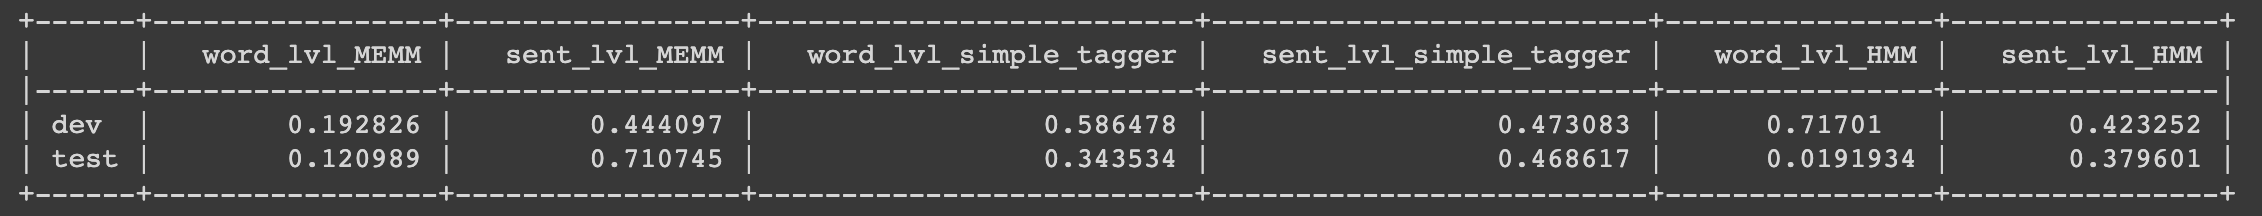



In [ ]:
# TO DO

# Random Example:
# results_acc = np.random.rand(2, 6)
# df_results = pd.DataFrame(results_acc,columns=['word_lvl_MEMM', 'sent_lvl_MEMM', 'word_lvl_simple_tagger', 'sent_lvl_simple_tagger', 'word_lvl_HMM', 'sent_lvl_HMM'])
# df_results.index = ['dev','test']
# print(tabulate(df_results, headers='keys', tablefmt='psql'))

**Improved Tagger**  

*This is an open question.*

Base on your general knowlege in the filed of ML, and what you learned in the NLP course so far;  
Create your own tagger, and **make sure to improve the scores on the test dataset.**

In [ ]:
class improved_tagger:
  def __init__(self):
    # TO DO
    pass

  def train(self, data) -> None:
    # TO DO
    pass

  def evaluate(self, data) -> tuple[float,float]:
    # TO DO
    pass

**Train & Evaluate**  
Use the class you created to train and evaluate your model.
Save & Print the eveluation scores.


In [ ]:
# TO DO

## Part 6 - Results

Print your results in the following format:


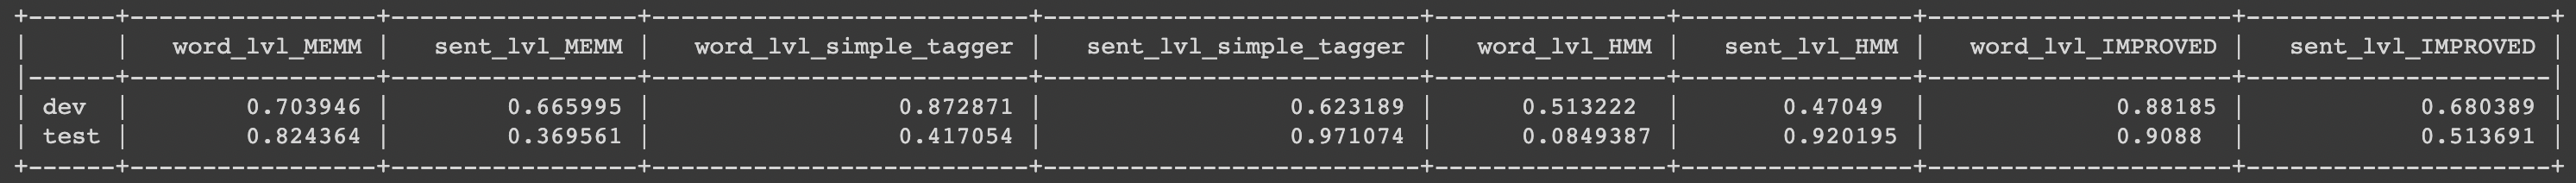

In [ ]:
# TO DO

Save the results in the dataframe to a CSV using this format:  
> `{student_ID1}_{Student_ID2}_part6.csv`  
> For example: 300123123_200321321_part6.csv

In [ ]:
# TO DO

<br><br><br>
Good Luck.